# **1 st option: OpenVINO™ integration with TensorFlow**







OpenVINO toolkit is a free toolkit facilitating the optimization of a deep learning model from a framework and deployment using an inference engine onto Intel hardware. This product delivers OpenVINO™ inline optimizations, which enhance inferencing performance of popular deep learning models with minimal code changes and without any accuracy drop.




OpenVINO™ integration with TensorFlow accelerates inference across many AI models on a variety of Intel® silicon such as:



1.   Intel® CPUs
2.   Intel® GPUs
1.   Intel® VPU











## What this document is about


*   We will be utilizing the most popular object detection architectures on TensorFlow Hub.
*    we will run inference on both OpenVINO and native Tensorflow

**Sequence of steps include**:-

1.   We download the models and images.
1.   Then we load them to be inferred on both native and OpenVINO
2.   We then have output detections to check whether the OPENVINO is affeting the accuracy.
1.   We then compare the inference of different models with and without OpenVINO.

















In [ ]:
import os
#get the current working directory
root_path = os.getcwd()

# setting the environment variable for inference optimizations
os.environ["OPENVINO_TF_CONVERT_VARIABLES_TO_CONSTANTS"] = "1"

#upgrading the pip
!python3 -m pip install --upgrade pip

#installing tensflow_hub which is the central part of the demonstartion
!python3 -m pip install opencv-python-headless matplotlib scipy tensorflow_hub

# Installing TensorFlow(2.9.2) & OpenVINO TensorFlow(2.2.0) 
# openvino-tensorflow version which we are downloading is having an dependency on tensorflow-cpu
!python3 -m pip install --force-reinstall tensorflow-cpu==2.9.2
!python3 -m pip install --force-reinstall openvino-tensorflow==2.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow_cpu-2.9.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (207.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached typing_extensions-4.4.0-py3-none-any.whl (26 kB)
  Using cached h5py-3.7.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (4.1 MB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached packaging-21.3-py3-none-any.whl (40 kB)
  Using cached wrapt-1.14.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (75 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl (1.6 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached termcol

### Import required packages 

In [ ]:
#importing all the required libraries
import io
import cv2
import time
import pathlib
import colorsys
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen
#### comments
import tensorflow as tf
import tensorflow_hub as hub
import openvino_tensorflow as ovtf


### Clone TensorFlow models : GitHub Repository


In [ ]:
#This repo has the models
!git clone --depth 1 https://github.com/tensorflow/models.git 


Cloning into 'models'...
remote: Enumerating objects: 3595, done.
remote: Counting objects: 100% (3595/3595), done.
remote: Compressing objects: 100% (2998/2998), done.
remote: Total 3595 (delta 947), reused 1508 (delta 543), pack-reused 0
Receiving objects: 100% (3595/3595), 47.08 MiB | 27.82 MiB/s, done.
Resolving deltas: 100% (947/947), done.


### Get Labels
Here we open and read a label file for the MSCOCO 80 classes dataset.

In [ ]:
# Download label map
!wget "https://raw.githubusercontent.com/openvinotoolkit/openvino_tensorflow/master/examples/notebooks/mscoco_label_map.txt"
#we check whether the label data is downloaded
labels = {}
with open("mscoco_label_map.txt") as f:
    for label_map in f.readlines():
        id = int(label_map.strip().split(":")[0])
        label_name = label_map.strip().split(":")[1]
        labels[id] = label_name
print(labels, len(labels))

--2022-11-23 04:08:41--  https://raw.githubusercontent.com/openvinotoolkit/openvino_tensorflow/master/examples/notebooks/mscoco_label_map.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 851 [text/plain]
Saving to: ‘mscoco_label_map.txt’

mscoco_label_map.tx 100%[===================>]     851  --.-KB/s    in 0s      

2022-11-23 04:08:41 (27.7 MB/s) - ‘mscoco_label_map.txt’ saved [851/851]

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: '

## Get Models and Images

In this section, we focus on setting up the models and inputs.

###  Set models and images
Set models:
Create a nested 'models' dictionary which includes model's following details:
 - Model's URL as 'model_url' : To Dowload the model
 - Model's path as 'model_dir' : Model's saved_model directory path

Set test image:
We are using input images available from the tensorflow/models github repo as an example. **Note**: You can also specify any image that you wish to test the models on by adding the name and location of the image into the below 'images' dictionary. Currently only local images are supported.

In [ ]:
# A nested dictionary of object detection models and its corresponding model urls

models = {
    "faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8" : {'model_url' : 'http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz','model_dir' : 'downloaded_models/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8/saved_model'},
    "efficientdet_d6_coco17_tpu-32" : {'model_url' : 'http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d6_coco17_tpu-32.tar.gz','model_dir' : 'downloaded_models/efficientdet_d6_coco17_tpu-32/saved_model'},
    "ssd_resnet50_v1_fpn_640x640_coco17_tpu-8" : {'model_url' : 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz', 'model_dir' : 'downloaded_models/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/saved_model'}
}


images = {
    'Beach' : 'models/research/object_detection/test_images/image2.jpg',
    'Dogs' : 'models/research/object_detection/test_images/image1.jpg'
}

#i chose the dog image you can choose the beach image
input_image = images["Dogs"] 

## Define input processing methods

In this section, we define methods useful for image and model loading, which give the right input formats to be used in inferencing.

In [ ]:
# model details
def get_model_details(model_name):
    if model_name in models:
        return models[model_name]

# loading the model
def load_model(model_name,input_model):
  print(f"Loading {model_name}...")
  model = hub.load(input_model)
  print(f"{model_name} loaded successfully!")
  return model

#image details
def get_image(image_name):
    if image_name in images:
        return images[image_name]

# loading the images
def load_image(input_image):
  print("Loading input image...")  
  image = None
  img_width, img_height = 0, 0
  image_data = cv2.imread(input_image)
  img_width, img_height = image_data.shape[1], image_data.shape[0]

  return np.array([image_data], dtype = np.uint8), img_height, img_width

In [ ]:
image, img_height, img_width = load_image(input_image) # Loading the input image


Loading input image...


### Download models


In [ ]:
#if downloaded_models and output_images not existed then we create that directory
if os.getcwd() == root_path and not os.path.exists("downloaded_models"):
    path = os.path.join(os.getcwd(),"downloaded_models")
    os.mkdir(path)
if os.getcwd() == root_path and not os.path.exists("output_images"):
    path = os.path.join(os.getcwd(),"output_images")
    os.mkdir(path)
    
if not os.getcwd() == root_path+"/downloaded_models":
    os.chdir("downloaded_models") 
if not os.listdir(os.getcwd()):
    for model_name in models:
        model_url = get_model_details(model_name)["model_url"]
        !wget "$model_url"
    for model_tar in os.listdir(os.getcwd()):
        !tar -zxvf "$model_tar"
os.chdir(root_path)

--2022-11-23 04:08:41--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.122.128, 2607:f8b0:4004:c09::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.122.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 470850141 (449M) [application/x-tar]
Saving to: ‘faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz’

faster_rcnn_resnet1 100%[===================>] 449.04M   168MB/s    in 2.7s    

2022-11-23 04:08:44 (168 MB/s) - ‘faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.tar.gz’ saved [470850141/470850141]

--2022-11-23 04:08:44--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d6_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.122.128, 2607:f8b0:4004:c09::80
Connecting to download.tensorflow.org (download.tensorflo

# Output processing method

In [ ]:
#this function generates colors for the bounding boxes detected.
def get_colors(class_names):
    hsv_tuples = [
        (x / len(class_names), 1., 1.) for x in range(len(class_names))
    ]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(
        map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
            colors))
    np.random.seed(10101)  # for same colors across runs.
    np.random.shuffle(colors)  # shuffle colors 
    np.random.seed(None)  
    return colors

# Function to detect bounded boxes to be drawn on the output image.
def get_coordinates(box, img_height, img_width):
    return [int(box[0]*img_height),int(box[1]*img_width), int(box[2]*img_height), int(box[3]*img_width)]

# function to add labels for the bounding boxes.
def add_label(image, text, color, coords):
    font = cv2.FONT_HERSHEY_PLAIN
    font_scale = 1.
    (text_width, text_height) = cv2.getTextSize(
        text, font, fontScale=font_scale, thickness=1)[0]

    padding = 5
    rect_height = text_height + padding * 2
    rect_width = text_width + padding * 2

    (x, y) = coords

    cv2.rectangle(image, (x, y), (x + rect_width, y - rect_height), color,
                  cv2.FILLED)
    cv2.putText(
        image,
        text, (x + padding, y - text_height + padding),
        font,
        fontScale=font_scale,
        color=(255, 255, 255),
        lineType=cv2.LINE_AA)

    return image

# function for drawing the bounding boxes.
def draw_boxes(image,
               boxes,
               classes,
               scores,
               class_names,
               colors,
               show_score=True):
    if classes is None or len(classes) == 0:
        return image

    for box, cls, score in zip(boxes, classes, scores):
        ymin, xmin, ymax, xmax = box
        
        class_name = class_names[cls]
        if show_score:
            label = '{} {:.2f}'.format(class_name, score)
        else:
            label = '{}'.format(class_name)

        # black: color(0,0,0)
        if colors == None:
            color = (0, 0, 0)
        else:
            color = colors[cls]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 1, cv2.LINE_AA)
        image = add_label(image, label, color, (xmin, ymin))

    return image

# function to visualize the predictions 
def visualize_ouput(model_name,predictions,img_height,img_width,isovtf):
    colors = get_colors(labels)
    class_ids = predictions["detection_classes"][0].numpy().astype("int")
    scores = predictions["detection_scores"][0].numpy()
    num_detections = predictions["num_detections"][0].numpy().astype("int")
    detection_boxes = predictions["detection_boxes"][0].numpy()
    conf_threshold = 0.4 # You can try increase/decrease threshold to see the output changes
    boxes = []
    confidence_scores = []
    classes = []
    for detection_index in range(num_detections):
        if scores[detection_index]<conf_threshold:
            continue
        else:
            confidence_scores.append(scores[detection_index])
            classes.append(class_ids[detection_index])
            boxes.append(get_coordinates(detection_boxes[detection_index], img_height, img_width))
            
    img_bbox = draw_boxes(cv2.imread(input_image), boxes, classes, scores,
                        labels, colors)
    if isovtf:
        output_image_name = model_name + "_OVTF" + "_detected_output"
    else:
        output_image_name = model_name + "_TF" + "_detected_output"
    cv2.imwrite("output_images/" + output_image_name + ".png", img_bbox)

# Inference Function

In [ ]:
def run_inference(model,image):
    """running the inference for output and performance results"""
    elapsed = 0.0
    total_time = 0.0
    num_iterations = 10 #You can increase/decrease number of iterations and see output changes

    print("Running 3 warmup inference iterations...")
    # run 3 warmup iterations
    for i in range(3):
        predictions = model(image)
    
    print("Running %d inference iterations..."%num_iterations)
    # capature the average performance results
    for i in range(num_iterations):
        start = time.time()
        model(image)
        elapsed = time.time() - start
        total_time += elapsed
    
    # calculate average inference time in milliseconds and rounding to 2 decimal points
    average_time = round((total_time/num_iterations)*1000,2)
                
    return predictions, average_time

### Run with OpenVINO™ integration with TensorFlow enabled


In [ ]:
# Enable OpenVINO integration 
ovtf.enable() 

# Define the backend to be enabled
backend_name = "CPU" 

# Print list of available backends
print('Available Backends:') 

# To determine available backends on your system, 'list_backends' API is used
backends_list = ovtf.list_backends() 
for backend in backends_list:
    print(f"\t{backend}")

# Set the backend
ovtf.set_backend(backend_name) 
print(f"OpenVINO integration with TensorFlow is enabled and device {backend_name} is set as backend.")

image, img_height, img_width = load_image(input_image) # Loading the input image

# disable TF Logging
os.environ["TF_CPP_MAX_VLOG_LEVEL"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# Record average latency of each model in this dict
ovtf_latency = {}

# Running all the models iteratively
for model_name in models:
    input_model = get_model_details(model_name)["model_dir"] # Get model location
    model = load_model(model_name,input_model) # Loading the model
    predictions,average_time = run_inference(model,image) # Running inference
    visualize_ouput(model_name, predictions, img_height, img_width, 1) # Visualizing the output. Here '1' is set to indicate model run on OVTF
    ovtf_latency[model_name] = int(average_time)
    print(f"Inference Successfully completed on OpenVINO integration with TensorFlow..! {model_name} model run on {backend_name} in {average_time} ms\n"),
    print(f"-----------------------")

Available Backends:
	CPU
OpenVINO integration with TensorFlow is enabled and device CPU is set as backend.
Loading input image...
Loading faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8...
faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 loaded successfully!
Running 3 warmup inference iterations...
Running 10 inference iterations...
Inference Successfully completed on OpenVINO integration with TensorFlow..! faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 model run on CPU in 9467.21 ms

-----------------------
Loading efficientdet_d6_coco17_tpu-32...
efficientdet_d6_coco17_tpu-32 loaded successfully!
Running 3 warmup inference iterations...
Running 10 inference iterations...
Inference Successfully completed on OpenVINO integration with TensorFlow..! efficientdet_d6_coco17_tpu-32 model run on CPU in 12278.49 ms

-----------------------
Loading ssd_resnet50_v1_fpn_640x640_coco17_tpu-8...
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 loaded successfully!
Running 3 warmup inference iterations...


### Run with native TensorFlow


In [ ]:
ovtf.disable() # Disable OpenVINO integration
print("OpenVINO integration with TensorFlow is disabled\n")

backend_name = "CPU" 

# Record average latency of each model in this dict
tf_latency = {}

image, img_height, img_width = load_image(input_image) # Load the input_image
for model_name in models:
    input_model = get_model_details(model_name)["model_dir"] # Get model location
    model = load_model(model_name,input_model) # Loading the model
    predictions,average_time = run_inference(model,image) # Running inference
    visualize_ouput(model_name, predictions, img_height, img_width, 0) # Visualizing the output. Here '0' is set to indicate model run on TF
    tf_latency[model_name] = int(average_time)
    print(f"Inference Successfully completed on OpenVINO integration with TensorFlow..! {model_name} model run on {backend_name} in {average_time} ms\n"),
    print(f"-----------------------")

OpenVINO integration with TensorFlow is disabled

Loading input image...
Loading faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8...
faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 loaded successfully!
Running 3 warmup inference iterations...
Running 10 inference iterations...
Inference Successfully completed on OpenVINO integration with TensorFlow..! faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8 model run on CPU in 9860.88 ms

-----------------------
Loading efficientdet_d6_coco17_tpu-32...
efficientdet_d6_coco17_tpu-32 loaded successfully!
Running 3 warmup inference iterations...
Running 10 inference iterations...
Inference Successfully completed on OpenVINO integration with TensorFlow..! efficientdet_d6_coco17_tpu-32 model run on CPU in 18222.8 ms

-----------------------
Loading ssd_resnet50_v1_fpn_640x640_coco17_tpu-8...
ssd_resnet50_v1_fpn_640x640_coco17_tpu-8 loaded successfully!
Running 3 warmup inference iterations...
Running 10 inference iterations...
Inference Successfully 

### Let's visualize the inferred images between Native TensorFlow and OpenVINO integration with TensorFlow


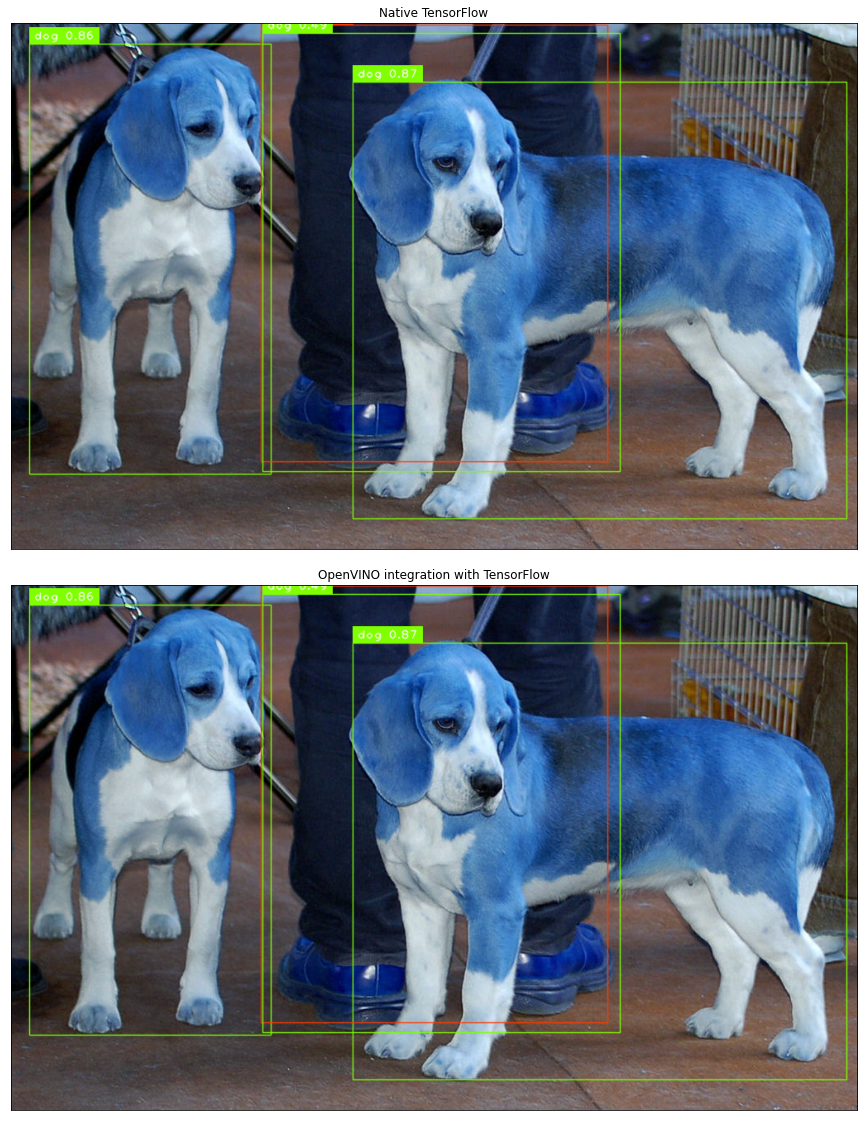

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

im_tf = cv2.imread("/content/output_images/efficientdet_d6_coco17_tpu-32_TF_detected_output.png")
im_ovtf = cv2.imread("/content/output_images/efficientdet_d6_coco17_tpu-32_OVTF_detected_output.png")

fig = plt.figure(figsize=(32, 20))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 share_all=True
                 )
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

grid[0].set_title("Native TensorFlow", fontdict=None, loc='center', color = "k")
grid[1].set_title("OpenVINO integration with TensorFlow", fontdict=None, loc='center', color = "k")

for ax, im in zip(grid, [im_tf, im_ovtf]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

# Let's plot the performance results


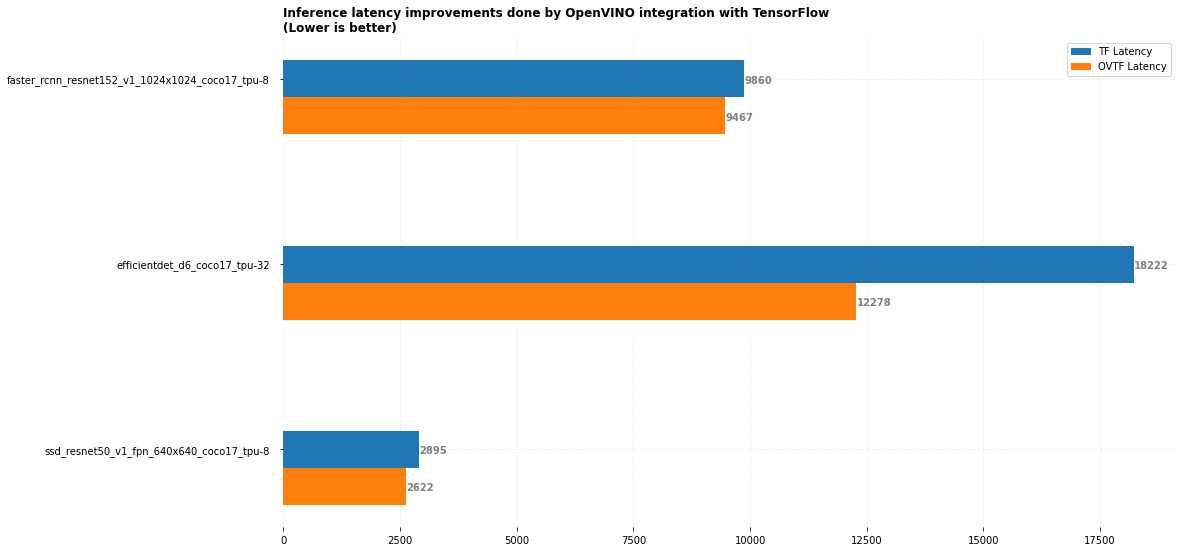

In [ ]:
# Init a 16x9 plot
fig, ax = plt.subplots(figsize=(16, 9))

# Plot the values
Y = np.arange(len(ovtf_latency))
ax.barh(Y, list(tf_latency.values()), height=0.2)
ax.barh(Y+0.2, list(ovtf_latency.values()), height=0.2)

# Set Y-axis labels and add Legend
plt.yticks(Y, tf_latency.keys())
ax.legend(('TF Latency','OVTF Latency'))

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(visible = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+10, i.get_y()+0.125,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')
 
# Add Plot Title
ax.set_title('Inference latency improvements done by OpenVINO integration with TensorFlow\n(Lower is better)', loc='left', fontweight='bold')

plt.show()